# Motor de Recomendación - Banco de Recursos DE SIFODS

## Origen de datos 

In [1]:
#Librerias
import pandas as pd 
import numpy as np
import pyodbc
import re 
import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Credenciales 
conn = pyodbc.connect(DRIVER = '{ODBC Driver 17 for SQL Server}',
                      SERVER = 'med000008646',
                      DATABASE = 'BD_STAGE',
                      UID = 'usconsulta',
                      PWD = 'consulta')

In [3]:
#Extraccion del dataset inical 
## maestro de cursos de la oferta formativa 
query1 = """SELECT  A.ID,
		A.TITULO, 
		A.RESUMEN,
		B.DESCRIPCION AS CATEGORIA , 
		C.DESCRIPCION AS TIPO_RECURSO,
		D.DESCRIPCION AS SUB_CATEGORIA, 
		E.DESCRIPCION AS SEGUNDA,
		F.DESCRIPCION AS TERCERA,
		G.DESCRIPCION AS CUARTA,
		A.DESCARGAS,
		A.VISTAS
	FROM [st].[SI_acfm.transaccional.accion_formativa_banco_recurso] A
	LEFT JOIN [st].[SI_dbo.maestro.parametros] B on A.CATEGORIA_ID = B.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] C on A.TIPORECURSO = C.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] D on A.SUB_CATEGORIA_ID = D.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] E on A.SEGUNDA_SUBCATEGORIA_ID=E.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] F on A.TERCERA_SUBCATEGORIA_ID=F.ID
	LEFT JOIN [st].[SI_dbo.maestro.parametros] G on A.CUARTA_SUBCATEGORIA_ID=G.ID
	WHERE A.ESTADO=1"""
    
banco_recursos_df = pd.read_sql_query(query1,conn)


## interacciones del usuario con sifods
query2 = """SELECT ID,
                    DNI,
                    ACCIONFORMATIVABANCORECURSOID,
                    PREFERENCIA,
                    VISTA,
                    DESCARGA,
                    CALIFICACION
            FROM [st].[SI_acfm.transaccional.banco_recurso_like]
            WHERE ESTADO=1"""
acciones_df = pd.read_sql_query(query2,conn)


#Cerrar la conexion
conn.close()

**DataFrame Extraidos**

In [4]:
banco_recursos_df.head(3)

ID                                             TITULO   
0   770                Comunicación 1: Cuaderno de trabajo  \
1  1423  Augdaiyaku 1 - Tajimat pujut augdaiyaku - Leng...   
2  1425  Augdaiyaku 2 - Tajimat pujut augdaiyaku - Leng...   

                                             RESUMEN           CATEGORIA   
0  Presenta actividades que permiten el desarroll...  Material Educativo  \
1  Portafolio de evidencias para estudiantes del ...  Material Educativo   
2  Portafolio de evidencias para estudiantes del ...  Material Educativo   

          TIPO_RECURSO SUB_CATEGORIA SEGUNDA TERCERA CUARTA  DESCARGAS  VISTAS  
0  Cuaderno de trabajo          None    None    None   None          2       9  
1  Cuaderno de trabajo          None    None    None   None          0       0  
2  Cuaderno de trabajo          None    None    None   None          0       0

In [5]:
acciones_df.head(3)

ID       DNI  ACCIONFORMATIVABANCORECURSOID  PREFERENCIA  VISTA  DESCARGA   
0   1  26718640                           2513        False      1         0  \
1   2  31036655                           2293        False      1         0   
2   3  71481859                           1216        False      1         0   

   CALIFICACION  
0             0  
1             0  
2             0

## Manipulación de Datos

**Banco de recursos** 

In [6]:
def reemplazar_special_carac(text):
    #Remover caracteres especiales de la columna
    pattern = r'[^a-zA-Z\sñÑáéíóúÁÉÍÓÚ]'
    return re.sub(pattern,'', text)

In [7]:
banco_recursos_df['TITULO'] = banco_recursos_df['TITULO'].apply(reemplazar_special_carac)
banco_recursos_df['RESUMEN'] = banco_recursos_df['RESUMEN'].apply(reemplazar_special_carac)

In [8]:
#### este codigo es de prueba
display(banco_recursos_df.query("ID == 3253").TITULO)

2168    Fascículo US Curso Aplicando estrategias basad...
Name: TITULO, dtype: object

In [9]:
banco_recursos_df.TITULO.head(3)

0                    Comunicación  Cuaderno de trabajo
1    Augdaiyaku   Tajimat pujut augdaiyaku  Lengua ...
2    Augdaiyaku   Tajimat pujut augdaiyaku  Lengua ...
Name: TITULO, dtype: object

In [10]:
banco_recursos_df.RESUMEN.head(3)

0    Presenta actividades que permiten el desarroll...
1    Portafolio de evidencias para estudiantes del ...
2    Portafolio de evidencias para estudiantes del ...
Name: RESUMEN, dtype: object

**Acciones Banco de Recursos**

In [11]:
#Quitar los registros que no estan en la lista de banco de recursos con interacciones
acciones_df_validos = acciones_df[acciones_df['ACCIONFORMATIVABANCORECURSOID'].isin(banco_recursos_df['ID'])]

In [12]:
acciones_df_validos =acciones_df_validos[acciones_df_validos['DESCARGA']>0]
acciones_df_validos

ID       DNI  ACCIONFORMATIVABANCORECURSOID  PREFERENCIA  VISTA   
68        69  03700206                           2500        False      1  \
69        70  03700206                           2503        False      0   
70        71  03700206                           2502        False      0   
71        72  03700206                           2501        False      0   
72        73  03700206                           2499        False      0   
...      ...       ...                            ...          ...    ...   
22555  31528  40460992                           3248        False      0   
22556  31529  40460992                           3247        False      0   
22557  31530  40460992                           3246        False      0   
22575  31548  25302217                           3247        False      0   
22610  31583  15640872                           3004        False      2   

       DESCARGA  CALIFICACION  
68            1             0  
69            1             0  
70            2             0  
71            1             0  
72            1             0  
...         ...           ...  
22555         1             0  
22556         1             0  
22557         1             0  
22575         1             0  
22610         1             0  

[3592 rows x 7 columns]

In [13]:
usuarios_con_interacciones = acciones_df_validos.groupby('DNI')['ACCIONFORMATIVABANCORECURSOID'].size()
usuarios_con_interacciones
print("# usuarios : %d" %len(usuarios_con_interacciones))
usuarios_seleccionados = usuarios_con_interacciones[usuarios_con_interacciones > 1].reset_index()[['DNI']]
print("# usuarios seleccionados %d"  %len(usuarios_seleccionados))

# usuarios : 413
# usuarios seleccionados 236


In [14]:
print("# de interaciones total : %d" %len(acciones_df_validos))

acciones_df_validos_2 = acciones_df_validos.merge(usuarios_seleccionados, how="right", left_on="DNI",right_on="DNI")

print("# de interacciones seleccionadas : %d" %len(acciones_df_validos_2))


# de interaciones total : 3592
# de interacciones seleccionadas : 3415


## Análisis Descriptivo Estadistico

In [13]:
print("# de recursos registrados : %d" %len(banco_recursos_df))

# de recursos registrados : 3029


CATEGORIA
Herramientas de apoyo docente       679
Material Educativo                 1800
Recursos de Acciones Formativas     550
dtype: int64


<Axes: title={'center': 'CATEGORIA BANCO DE RECURSOS'}, ylabel='CATEGORIA'>

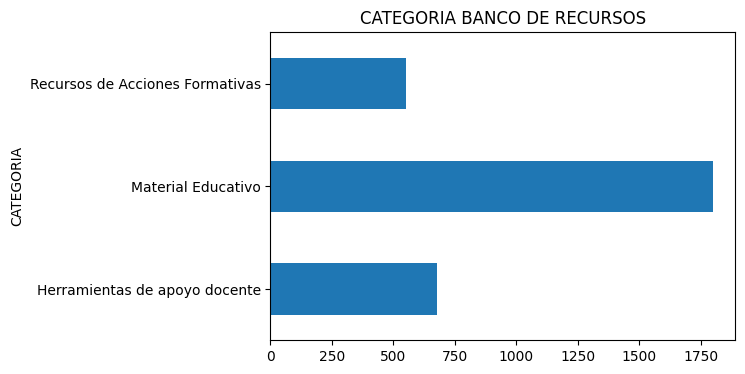

In [14]:
g_categoria = banco_recursos_df.groupby('CATEGORIA').size()
print(g_categoria)
g_categoria.plot(kind='barh',title='CATEGORIA BANCO DE RECURSOS',figsize=(6,4))

TIPO_RECURSO
Infografía                3
Modelado                  5
Lámina                    9
Audio                    11
Manual                   16
Orientaciones            31
Prueba                   33
Registro                 33
Cartilla                 39
Texto escolar            49
Sílabo                   89
Caja de herramientas    169
Guía                    186
Ficha                   249
Video                   262
Libro                   279
Texto                   285
Fascículo               332
Cuaderno de trabajo     949
dtype: int64


<Axes: title={'center': 'Tipos de Recursos'}, ylabel='TIPO_RECURSO'>

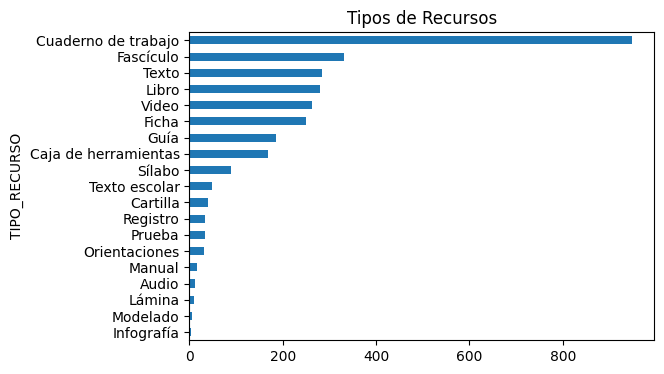

In [15]:
g_tiporecurso = banco_recursos_df.groupby('TIPO_RECURSO').size().sort_values()
print(g_tiporecurso)
g_tiporecurso.plot(kind='barh',title='Tipos de Recursos',figsize=(6,4))

<Axes: title={'center': 'Frecuencia de Descargas del Banco de Recursos - SIFODS'}, ylabel='Frequency'>

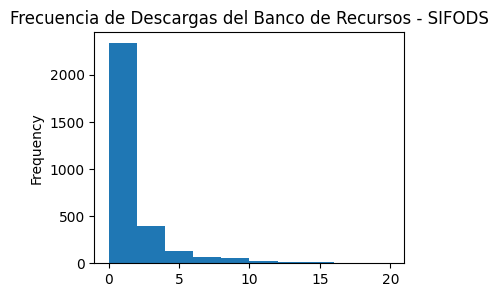

In [17]:
v1 = banco_recursos_df['DESCARGAS']
v1.plot.hist(title ='Frecuencia de Descargas del Banco de Recursos - SIFODS',figsize=(4,3),range=(0,20))

<Axes: title={'center': 'Frecuencia de VISTAS del Banco de Recursos - SIFODS'}, ylabel='Frequency'>

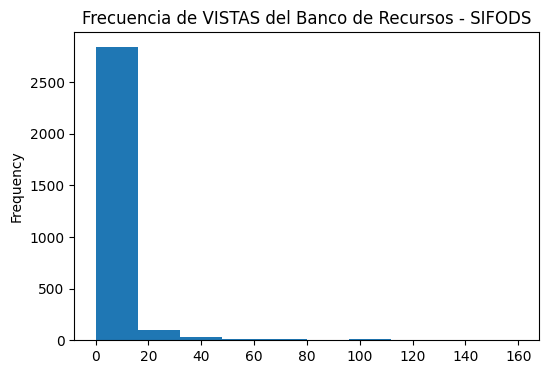

In [18]:
v2 = banco_recursos_df['VISTAS']
v2.plot.hist(title ='Frecuencia de VISTAS del Banco de Recursos - SIFODS',figsize=(6,4),range=(0,160))

<Axes: xlabel='DESCARGA', ylabel='VISTA'>

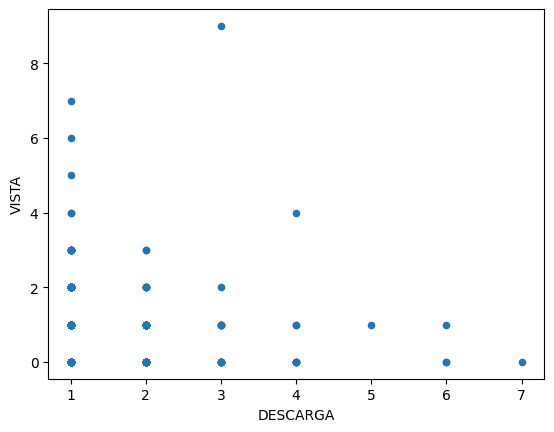

In [19]:
acciones_df_validos.plot(kind="scatter",x='DESCARGA',y='VISTA')

In [200]:
# Numero de docentes unicos 
num_docentes=acciones_df_validos['DNI'].unique()
print("# de docentes con acciones en el banco de recursos : "  + str(len(num_docentes)))

# de docentes con acciones en el banco de recursos : 413


In [201]:
num_recursos = acciones_df_validos['ACCIONFORMATIVABANCORECURSOID'].unique()
print("# de recursos descargados : " + str(len(num_recursos)))

# de recursos descargados : 1196


In [202]:
#Numero de registros total para el modelo
num_registros_total = len(acciones_df_validos)
print("# registros para el modelo : " + str(num_registros_total))

# registros para el modelo : 3592


## Selección de Variables

- Exclusión de valores con descarga = 0 

In [15]:
porcentaje_vista_validos = round((len(acciones_df_validos[acciones_df_validos["VISTA"] >= 1])/ len(acciones_df_validos)*100),1)
porcentaje_descarga_validos = round((len(acciones_df_validos[acciones_df_validos["DESCARGA"] >= 1])/ len(acciones_df_validos)*100),1)
porcentaje_calificacion_validos = round((len(acciones_df_validos[acciones_df_validos["CALIFICACION"] >= 1])/ len(acciones_df_validos)*100),1)


print("Porcentaje de datos en la variable VISTA: " + str(porcentaje_vista_validos) + "%")
print("Porcentaje de datos en la variable DESCARGA: " + str(porcentaje_descarga_validos) + "%")
print("Porcentaje de datos en la variable CALIFICACIÓN: " + str(porcentaje_calificacion_validos) + "%")

Porcentaje de datos en la variable VISTA: 7.0%
Porcentaje de datos en la variable DESCARGA: 100.0%
Porcentaje de datos en la variable CALIFICACIÓN: 0.3%


In [16]:
# Recurso mas descargado
recurso_popular_df =acciones_df_validos.groupby('ACCIONFORMATIVABANCORECURSOID')['DESCARGA'].sum().to_frame('SUMD').reset_index()
recurso_popular_df = recurso_popular_df.merge(banco_recursos_df,how='inner',left_on='ACCIONFORMATIVABANCORECURSOID',right_on='ID').sort_values(by='DESCARGAS',ascending=False)
recurso_popular_df[['ID','TITULO','SUMD']].head(5)

ID                                             TITULO  SUMD
859  2516  Comunicación VI ciclo Recurso  bibliográfico A...    47
677  2330  Guía para la investigación y citado de fuentes...    43
666  2318  Fichas de actividades de la competencia Indaga...    29
949  2787               Fascículo U Curso Ciudadanía digital    26
857  2514  Comunicación VI ciclo Recurso  bibliográfico C...    21

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords #librerias para los stopwords
import scipy
import sklearn

In [207]:
banco_recursos_df.head(3)

ID                                             TITULO   
0   770                 Comunicación 1 Cuaderno de trabajo  \
1  1423  Augdaiyaku 1  Tajimat pujut augdaiyaku  Lengua...   
2  1425  Augdaiyaku 2  Tajimat pujut augdaiyaku  Lengua...   

                                             RESUMEN           CATEGORIA   
0  Presenta actividades que permiten el desarroll...  Material Educativo  \
1  Portafolio de evidencias para estudiantes del ...  Material Educativo   
2  Portafolio de evidencias para estudiantes del ...  Material Educativo   

          TIPO_RECURSO SUB_CATEGORIA SEGUNDA TERCERA CUARTA  DESCARGAS  VISTAS  
0  Cuaderno de trabajo          None    None    None   None          2       9  
1  Cuaderno de trabajo          None    None    None   None          0       0  
2  Cuaderno de trabajo          None    None    None   None          0       0

In [208]:
acciones_df[['ID','DNI','ACCIONFORMATIVABANCORECURSOID','DESCARGA']]

ID       DNI  ACCIONFORMATIVABANCORECURSOID  DESCARGA
0          1  26718640                           2513         0
1          2  31036655                           2293         0
2          3  71481859                           1216         0
3          4  09224186                            109         0
4          5  09224186                           2327         0
...      ...       ...                            ...       ...
22747  31720  75182688                           3253         0
22748  31721  75182688                           3252         0
22749  31722  10174066                           1396         0
22750  31723  46126327                           3255         0
22751  31724  40434440                           3250         0

[22752 rows x 4 columns]

In [19]:
acciones_full_df = acciones_df_validos_2[['ID','DNI','ACCIONFORMATIVABANCORECURSOID','DESCARGA']]

In [210]:
interactions_indexed_df = acciones_full_df.set_index("DNI")

In [24]:
#ingnorar las palabras sin semantica del español
stopwords_list = stopwords.words('spanish')

vectorizer = TfidfVectorizer(analyzer='word',
                            ngram_range=(1,2),
                            min_df=5,
                            max_df=0.7,
                            max_features=500,
                            stop_words=stopwords_list)

item_ids = banco_recursos_df['ID'].tolist()
tfidf_matrix = vectorizer.fit_transform(banco_recursos_df['TITULO'] +" " +banco_recursos_df['RESUMEN'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix


<3029x500 sparse matrix of type '<class 'numpy.float64'>'
	with 113872 stored elements in Compressed Sparse Row format>

In [406]:
# def get_item_profile(item_id):
#     idx = item_ids.index(item_id)
#     item_profile = tfidf_matrix[idx:idx+1]
#     return item_profile

# def get_item_profiles(ids):
#     item_profiles_list = [get_item_profile(x) for x in ids]
#     item_profiles = scipy.sparse.vstack(item_profiles_list)
#     return item_profiles

# def build_users_profile(person_id, interactions_indexed_df):
#     interaccion_person_df = interactions_indexed_df.loc[person_id]
#     user_item_profiles = get_item_profiles(acciones_full_df['ACCIONFORMATIVABANCORECURSOID'])

#     user_item_strengths = np.array(acciones_full_df['DESCARGA']).reshape(-1,1)
#     #Media ponderada de los perfiles de los elementos según la fuerza de las interacciones
#     user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
#     user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_strengths_weighted_avg))
#     return user_profile_norm

# def build_users_profiles():
#     interactions_indexed_df = acciones_full_df[acciones_full_df['ACCIONFORMATIVABANCORECURSOID'].isin(banco_recursos_df['ID'])].set_index('DNI')
#     user_profiles = {}
#     for person_id in interactions_indexed_df.index.unique():
#         user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    # return user_profiles

In [407]:
# user_profiles = build_users_profiles()

413

In [448]:
user_profiles

{'03700206': array([[1.64864822e-01, 8.62681759e-02, 1.67957443e-03, 1.67957443e-03,
         2.09128046e-04, 1.50085119e-03, 0.00000000e+00, 5.70513915e-05,
         6.91540625e-05, 1.91406694e-02, 1.46697546e-02, 0.00000000e+00,
         0.00000000e+00, 2.45550906e-02, 0.00000000e+00, 7.04238760e-05,
         7.04238760e-05, 1.84692793e-03, 7.30202410e-03, 6.95623558e-02,
         1.67957443e-03, 1.67957443e-03, 6.50500403e-02, 1.80255018e-02,
         2.45161341e-02, 1.43272208e-01, 2.55368607e-03, 2.73329256e-04,
         1.48841242e-03, 6.59533964e-04, 7.72941924e-02, 1.50085119e-03,
         0.00000000e+00, 2.72928261e-04, 3.19294578e-03, 6.91540625e-05,
         4.36159693e-02, 2.56212411e-02, 1.37529674e-02, 1.84706413e-03,
         1.50085119e-03, 6.33536193e-05, 6.33536193e-05, 1.06259891e-02,
         0.00000000e+00, 3.43839327e-02, 5.02119016e-02, 2.71243226e-03,
         3.93395333e-03, 4.53574806e-03, 1.50085119e-03, 3.92926146e-02,
         5.58343940e-02, 1.50085119e-03

In [449]:
acciones_full_df.DNI.unique()

array(['03700206', '07686262', '45505745', '45319612', '21577519',
       '02435644', '04083996', '43144815', '32973950', '44828632',
       '43055733', '40365342', '45163338', '44426678', '41850579',
       '45911000', '46101716', '80390655', '01802678', '40414194',
       '32730366', '42375650', '17439717', '40118111', '43168215',
       '41548355', '18111213', '06268783', '24994035', '09935871',
       '03507684', '41222428', '28312974', '47511349', '18192659',
       '01159431', '32982667', '01547043', '45109124', '24702114',
       '16704463', '77485710', '40114769', '44143966', '40308486',
       '27669058', '70401020', '41370375', '23942578', '48000690',
       '21143000', '31035715', '07644833', '40049216', '42239016',
       '26693096', '28296833', '17539727', '41532951', '08210546',
       '43289073', '25444748', '21260266', '31635037', '26709922',
       '15739159', '09257355', '43127661', '04216699', '10042646',
       '20073857', '40736467', '19322370', '72939522', '433379

In [456]:
myprofile = user_profiles['75182688']
print(myprofile.shape)

pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles['75182688'].flatten().tolist()), key=lambda x: -x[1])[:20],columns=['token', 'peso'])

(1, 500)


token      peso
0              ficha  0.291258
1              ciclo  0.235534
2           vi ciclo  0.194040
3                 vi  0.189386
4    ficha actividad  0.182310
5                vii  0.178054
6          vii ciclo  0.175453
7         matemática  0.166422
8          actividad  0.164865
9            escolar  0.148162
10          refuerzo  0.147998
11  refuerzo escolar  0.147998
12       estudiantes  0.144043
13       aprendizaje  0.143272
14             curso  0.138982
15               uso  0.129830
16      comunicación  0.128946
17         problemas  0.123112
18           recurso  0.122688
19          docentes  0.119360

## Modelo contenido

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidfvec = TfidfVectorizer(min_df=2,ngram_range=(2,3), max_df=0.7,stop_words=stopwords_list)
vectorized_data = tfidfvec.fit_transform(banco_recursos_df['TITULO']+" "+banco_recursos_df['RESUMEN'])
print(tfidfvec.get_feature_names_out())

['abarca unidad' 'abarca unidad desarrolla' 'abecedario cuento' ...
 'útiles vida' 'útiles vida ciudad' 'útiles vida través']


In [572]:
print(vectorized_data.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
tfidf = pd.DataFrame(vectorized_data.toarray(),
                            columns=tfidfvec.get_feature_names_out())
tfidf.index = banco_recursos_df['ID']
tfidf                            

abarca unidad  abarca unidad desarrolla  abecedario cuento   
ID                                                                 
770             0.0                       0.0                0.0  \
1423            0.0                       0.0                0.0   
1425            0.0                       0.0                0.0   
1430            0.0                       0.0                0.0   
1432            0.0                       0.0                0.0   
...             ...                       ...                ...   
3218            0.0                       0.0                0.0   
3210            0.0                       0.0                0.0   
3211            0.0                       0.0                0.0   
3212            0.0                       0.0                0.0   
3213            0.0                       0.0                0.0   

      abecedario cuento niños  abiertos escucho  abiertos escucho cuento   
ID                                                                         
770                       0.0               0.0                      0.0  \
1423                      0.0               0.0                      0.0   
1425                      0.0               0.0                      0.0   
1430                      0.0               0.0                      0.0   
1432                      0.0               0.0                      0.0   
...                       ...               ...                      ...   
3218                      0.0               0.0                      0.0   
3210                      0.0               0.0                      0.0   
3211                      0.0               0.0                      0.0   
3212                      0.0               0.0                      0.0   
3213                      0.0               0.0                      0.0   

      abiertos veo  abiertos veo cuento  abitedi icaid   
ID                                                       
770            0.0                  0.0            0.0  \
1423           0.0                  0.0            0.0   
1425           0.0                  0.0            0.0   
1430           0.0                  0.0            0.0   
1432           0.0                  0.0            0.0   
...            ...                  ...            ...   
3218           0.0                  0.0            0.0   
3210           0.0                  0.0            0.0   
3211           0.0                  0.0            0.0   
3212           0.0                  0.0            0.0   
3213           0.0                  0.0            0.0   

      abitedi icaid tantiate  ...  útil docentes eib  útil respecto   
ID                            ...                                     
770                      0.0  ...                0.0            0.0  \
1423                     0.0  ...                0.0            0.0   
1425                     0.0  ...                0.0            0.0   
1430                     0.0  ...                0.0            0.0   
1432                     0.0  ...                0.0            0.0   
...                      ...  ...                ...            ...   
3218                     0.0  ...                0.0            0.0   
3210                     0.0  ...                0.0            0.0   
3211                     0.0  ...                0.0            0.0   
3212                     0.0  ...                0.0            0.0   
3213                     0.0  ...                0.0            0.0   

      útil respecto cómo  útiles acercamiento  útiles acercamiento mundo   
ID                                                                         
770                  0.0                  0.0                        0.0  \
1423                 0.0                  0.0                        0.0   
1425                 0.0                  0.0                        0.0   
1430                 0.0                  0.0                        0.0 

In [34]:
from sklearn.metrics.pairwise import cosine_similarity


cosine_similarity_array = cosine_similarity(tfidf)

In [575]:
tfidf

abarca unidad  abarca unidad desarrolla  abecedario cuento   
ID                                                                 
770             0.0                       0.0                0.0  \
1423            0.0                       0.0                0.0   
1425            0.0                       0.0                0.0   
1430            0.0                       0.0                0.0   
1432            0.0                       0.0                0.0   
...             ...                       ...                ...   
3218            0.0                       0.0                0.0   
3210            0.0                       0.0                0.0   
3211            0.0                       0.0                0.0   
3212            0.0                       0.0                0.0   
3213            0.0                       0.0                0.0   

      abecedario cuento niños  abiertos escucho  abiertos escucho cuento   
ID                                                                         
770                       0.0               0.0                      0.0  \
1423                      0.0               0.0                      0.0   
1425                      0.0               0.0                      0.0   
1430                      0.0               0.0                      0.0   
1432                      0.0               0.0                      0.0   
...                       ...               ...                      ...   
3218                      0.0               0.0                      0.0   
3210                      0.0               0.0                      0.0   
3211                      0.0               0.0                      0.0   
3212                      0.0               0.0                      0.0   
3213                      0.0               0.0                      0.0   

      abiertos veo  abiertos veo cuento  abitedi icaid   
ID                                                       
770            0.0                  0.0            0.0  \
1423           0.0                  0.0            0.0   
1425           0.0                  0.0            0.0   
1430           0.0                  0.0            0.0   
1432           0.0                  0.0            0.0   
...            ...                  ...            ...   
3218           0.0                  0.0            0.0   
3210           0.0                  0.0            0.0   
3211           0.0                  0.0            0.0   
3212           0.0                  0.0            0.0   
3213           0.0                  0.0            0.0   

      abitedi icaid tantiate  ...  útil docentes eib  útil respecto   
ID                            ...                                     
770                      0.0  ...                0.0            0.0  \
1423                     0.0  ...                0.0            0.0   
1425                     0.0  ...                0.0            0.0   
1430                     0.0  ...                0.0            0.0   
1432                     0.0  ...                0.0            0.0   
...                      ...  ...                ...            ...   
3218                     0.0  ...                0.0            0.0   
3210                     0.0  ...                0.0            0.0   
3211                     0.0  ...                0.0            0.0   
3212                     0.0  ...                0.0            0.0   
3213                     0.0  ...                0.0            0.0   

      útil respecto cómo  útiles acercamiento  útiles acercamiento mundo   
ID                                                                         
770                  0.0                  0.0                        0.0  \
1423                 0.0                  0.0                        0.0   
1425                 0.0                  0.0                        0.0   
1430                 0.0                  0.0                        0.0 

In [650]:
acciones_df_validos[acciones_df_validos['DNI']=='00103604']

ID       DNI ACCIONFORMATIVABANCORECURSOID  PREFERENCIA  VISTA   
20868  29841  00093691                          2291        False      0  \
20869  29842  00093691                          2268        False      0   

       DESCARGA  CALIFICACION  
20868         1             0  
20869         1             0

In [701]:
book_jun = acciones_df_validos_2[acciones_df_validos_2['DNI']=='00103604']['ACCIONFORMATIVABANCORECURSOID'].to_list()
book_jun


[2272, 2271, 2270, 2269, 2268, 1044, 1043, 1042, 1041, 1040, 770]

In [702]:
jun_book = tfidf.reindex(book_jun)
jun_book

abarca unidad  abarca unidad desarrolla  abecedario cuento   
ID                                                                 
2272            0.0                       0.0                0.0  \
2271            0.0                       0.0                0.0   
2270            0.0                       0.0                0.0   
2269            0.0                       0.0                0.0   
2268            0.0                       0.0                0.0   
1044            0.0                       0.0                0.0   
1043            0.0                       0.0                0.0   
1042            0.0                       0.0                0.0   
1041            0.0                       0.0                0.0   
1040            0.0                       0.0                0.0   
770             0.0                       0.0                0.0   

      abecedario cuento niños  abiertos escucho  abiertos escucho cuento   
ID                                                                         
2272                      0.0               0.0                      0.0  \
2271                      0.0               0.0                      0.0   
2270                      0.0               0.0                      0.0   
2269                      0.0               0.0                      0.0   
2268                      0.0               0.0                      0.0   
1044                      0.0               0.0                      0.0   
1043                      0.0               0.0                      0.0   
1042                      0.0               0.0                      0.0   
1041                      0.0               0.0                      0.0   
1040                      0.0               0.0                      0.0   
770                       0.0               0.0                      0.0   

      abiertos veo  abiertos veo cuento  abitedi icaid   
ID                                                       
2272           0.0                  0.0            0.0  \
2271           0.0                  0.0            0.0   
2270           0.0                  0.0            0.0   
2269           0.0                  0.0            0.0   
2268           0.0                  0.0            0.0   
1044           0.0                  0.0            0.0   
1043           0.0                  0.0            0.0   
1042           0.0                  0.0            0.0   
1041           0.0                  0.0            0.0   
1040           0.0                  0.0            0.0   
770            0.0                  0.0            0.0   

      abitedi icaid tantiate  ...  útil docentes eib  útil respecto   
ID                            ...                                     
2272                     0.0  ...                0.0            0.0  \
2271                     0.0  ...                0.0            0.0   
2270                     0.0  ...                0.0            0.0   
2269                     0.0  ...                0.0            0.0   
2268                     0.0  ...                0.0            0.0   
1044                     0.0  ...                0.0            0.0   
1043                     0.0  ...                0.0            0.0   
1042                     0.0  ...                0.0            0.0   
1041                     0.0  ...                0.0            0.0   
1040                     0.0  ...                0.0            0.0   
770                      0.0  ...                0.0            0.0   

      útil respecto cómo  útiles acercamiento  útiles acercamiento mundo   
ID                                                                         
2272                 0.0                  0.0                        0.0  \
2271                 0.0                  0.0                        0.0   
2270                 0.0                  0.0                        0.0   
2269                 0.0                  0.0                        0.0 

In [703]:
jun_profile = jun_book.mean()
print(jun_profile.sort_values(ascending=False))

diversos tipos textos           0.217929
diversos tipos                  0.217929
tipos textos                    0.208375
lengua materna                  0.161056
textos lengua                   0.121901
                                  ...   
docentes permita                0.000000
docentes permita adecuar        0.000000
docentes permita diseñar        0.000000
docentes permita implementar    0.000000
útiles vida través              0.000000
Length: 15389, dtype: float64


In [704]:
#crear un subconjunto de solo los recursos que no descargó
non_users_recursos=tfidf.drop(book_jun, axis=0)

#Calcula el indice de similitud de coseno entre todas las filas 
user_prof_similarities= cosine_similarity(jun_profile.values.reshape(1,-1),non_users_recursos)

#Guarda en un dataframe 
user_similariity_df = pd.DataFrame(user_prof_similarities.T,
                                   index=non_users_recursos.index,
                                   columns=['Score'])

In [705]:
sorted_similarity_df = user_similariity_df.sort_values(by='Score', ascending=False)
sorted_similarity_df

Score
ID            
2273  0.981029
2296  0.327022
2295  0.327022
1048  0.327022
1049  0.327022
...        ...
1207  0.000000
1206  0.000000
1205  0.000000
1204  0.000000
3213  0.000000

[3018 rows x 1 columns]

In [649]:
acciones_df_validos['ACCIONFORMATIVABANCORECURSOID']=acciones_df_validos.ACCIONFORMATIVABANCORECURSOID .astype('object')

In [118]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile= tfidf[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles = []
    item_profile_list = [get_item_profile(x) for x in ids]
    item_profiles = pd.concat(item_profiles + item_profile_list)
    return item_profiles


def build_users_profile(person_id, interacciones_indexed_df):
    
    interactions_person_df = interacciones_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['ACCIONFORMATIVABANCORECURSOID'])

    user_item_strength = user_item_profiles.mean()
    
    non_resources = tfidf.drop(interactions_person_df['ACCIONFORMATIVABANCORECURSOID'] , axis= 0)
    
    resources_similarities = cosine_similarity(user_item_strength.values.reshape(1,-1),non_resources)

    user_similarities_df = pd.DataFrame(resources_similarities.T,
                                       index=non_resources.index,
                                        columns=['Score']).reset_index()
    sorted_similarity_df = user_similarities_df.sort_values(by='Score', ascending=False)
    sorted_similarity_df_2 = sorted_similarity_df.head(5)
    sorted_similarity_df_2['DNI']= person_id

    return sorted_similarity_df_2


def build_users_profiles():
    interacciones_indexed_df = acciones_df_validos_2[acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID']\
                                                   .isin(banco_recursos_df['ID'])].set_index('DNI')
    usuario_perfiles=pd.DataFrame([])
    for persona_id in interacciones_indexed_df.index.unique():
        usuario_perfiles = pd.concat([usuario_perfiles , build_users_profile(persona_id, interacciones_indexed_df)])
    return usuario_perfiles

In [95]:
interacciones_indexed_df = acciones_df_validos_2[acciones_df_validos_2['ACCIONFORMATIVABANCORECURSOID']\
                                                   .isin(banco_recursos_df['ID'])].set_index('DNI')

In [101]:
k1 = build_users_profile('00103604',interacciones_indexed_df)
k1

ID     Score       DNI
25   2273  0.981029  00103604
9    2296  0.327022  00103604
8    2295  0.327022  00103604
560  1048  0.327022  00103604
561  1049  0.327022  00103604

In [119]:
x1=build_users_profiles()

In [122]:
x1.head(16)

ID     Score       DNI
1556  1841  0.709990  00067813
1576  2087  0.694860  00067813
1573  2084  0.694860  00067813
1465  1982  0.694860  00067813
1494  2012  0.694860  00067813
568   1047  0.821893  00093691
6     2293  0.821893  00093691
566   1045  0.821893  00093691
26    2270  0.821893  00093691
562   1041  0.821893  00093691
25    2273  0.981029  00103604
9     2296  0.327022  00103604
8     2295  0.327022  00103604
560   1048  0.327022  00103604
561   1049  0.327022  00103604
2799  2409  0.279010  00120281